# How to use the Connectome Simulation in PyTorch

Welcome to the repository! In this file, we're going to walk through how to simulate the connectome using PyTorch, step by step.

First, we're going to start with our directory configurations

# Directories and Setup

These are the paths to the various directories where all of the data we will reference comes from. 

In [1]:
config_dirs = {
    'path_res': '../results/torch_data/',      # directory to store results
    'path_comp': '../data/Completeness_783.csv',    # csv of the complete list of FlyWire neurons
    'path_conn': '../data/Connectivity_783.parquet', # connectivity data
    'path_wt': '../data', # weight directory
}

Next we list all of our output neurons. These are the neuron IDs of the descending neurons that we care about. These descending neurons may be used to control the body of the fly.

In [8]:
flyid2name = { }
#P9_oDN1 corresponds to forward velocity
P9_oDN1_left = 720575940626730883
P9_oDN1_right = 720575940620300308
P9_left = 720575940627652358
P9_right =720575940635872101
#DNa01 and DNa02 correspond to turning
DNa01_right = 720575940627787609
DNa01_left = 720575940644438551
DNa02_right = 720575940629327659
DNa02_left = 720575940604737708
#MDN, "Moonwalker descending neurons" are backwards walking/escape/startle response
MDN_1, MDN_2, MDN_3, MDN_4 = 720575940616026939, 720575940631082808, 720575940640331472,720575940610236514
#Giant Fiber corresponds to escape
Giant_Fiber_1, Giant_Fiber_2 = 720575940622838154,720575940632499757
#MN9 corresponds to proboscis motor neuron, and corresponds to feeding.
MN9_left = 720575940660219265
MN9_right = 720575940618238523
#aDN1 correspond to antennal grooming
aDN1_right = 720575940616185531
aDN1_left = 720575940624319124


flyid2name[P9_oDN1_left]=       "P9_oDN1_left"
flyid2name[P9_oDN1_right]=      "P9_oDN1_right"
flyid2name[P9_left]=    "P9_left"
flyid2name[P9_right]=   "P9_right"
flyid2name[DNa01_right]=        "DNa01_right"
flyid2name[DNa01_left]= "DNa01_left"
flyid2name[DNa02_right]=        "DNa02_right"
flyid2name[DNa02_left]= "DNa02_left"
flyid2name[MDN_1]= "MDN_1"
flyid2name[MDN_2]= "MDN_2"
flyid2name[MDN_3]= "MDN_3"
flyid2name[MDN_4]= "MDN_4"
flyid2name[Giant_Fiber_1]= "Giant_Fiber_1"
flyid2name[Giant_Fiber_2]= "Giant_Fiber_2"
flyid2name[MN9_left]= "MN9_left"
flyid2name[MN9_right]= "MN9_right"
flyid2name[aDN1_right]= "aDN1_right"
flyid2name[aDN1_left]= "aDN1_left"

output_neurons = [P9_oDN1_left, P9_oDN1_right, DNa01_right, DNa01_left, DNa02_right, DNa02_left, MDN_1, MDN_2, MDN_3, MDN_4, Giant_Fiber_1, Giant_Fiber_2, MN9_left, MN9_right, aDN1_right, aDN1_left]

Next, let's import the libraries we're going to need from here on out

In [9]:
import torch    # PyTorch, what we are using for numerical processing on GPU
import time     # timing code
from tqdm.notebook import tqdm  # progress bar for loops
import matplotlib.pyplot as plt # plotting library
import .src.utils as utils   # custom utilities for this project
import src.models as models # custom models for this project

ModuleNotFoundError: No module named 'src'

We are also going to throw in a warning filter, just because we use sparse tensors which are currently beta in PyTorch (they have been in beta for years). This line has no effect on the actual code, it just suppresses an annoying warning which occurs every time you first use a sparse tensor.

In [ ]:
import warnings
warnings.filterwarnings('ignore', '.*Sparse CSR tensor support is in beta state.*')

# Simulation Setup

Now that the boilerplate is out of the way, let's get to running our actual simulation. We're going to start by defining the stimulation paradigm we will use for out network, with both a rate and target locations

In [8]:
stim_rate = 100
P9s = [P9_left, P9_right]   # we will stimulate P9 neurons in this example

Next, we will import some utility hash tables/dictionaries which let us easily map from flywire IDs to numeric IDs

In [19]:
flyid2i, i2flyid = utils.get_hash_tables(config_dirs['path_comp'])

Here we have our simulation parameter dictionary. Note the units given in the comments, unlike Brian2 Pytorch doesn't have native support for units, so all parameters need to be scaled into these domains.

Within the `sim_params`, `dt` corresponds to the euler integration timestep. This code does not do adaptive stepping, in general keep this as small as possible for improved numeric stability. The `batch_size` corresponds to how many models to run in parallel at once, and `t_sim` is the total simulation time.

In [15]:
sim_params = {
    'dt': 0.1,               # time step (ms)
    't_sim': 1000.0,         # total simulation time (ms)
    'batch_size': 1,        # batch size
}

Using these parameters, we can compute things such as the number of simulation steps we will need

In [14]:
num_steps = int(sim_params['t_sim'] / sim_params['dt'])

Finally, we need to set which device our code runs on.

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


# Creating our Model

Now, it is time for us to create our connectome model. Let's start with our model parameters

In [16]:
model_params = {
    'tauSyn': 5.0,    # ms
    'tDelay': 1.8,    # ms
    'v0': -52.0,      # mV
    'vReset': -52.0,  # mV
    'vRest': -52.0,   # mV
    'vThreshold': -45.0,  # mV
    'tauMem': 20.0,   # ms
    'tRefrac': 2.2,    # ms
    'scalePoisson': 250, # scaling factor for poisson input
    'wScale': 0.275,      # scaling factor for synaptic weights
}

Next, we need to get the weights for our model. These are a sparse tensor which represents the weighted adjacency matrix of the entire connectome. This happens via a utility function, which first tries to import the matrix from disc. If it doesn't exist yet, the weights are then generated. By default, the weight format is CSR, which is the best format for matrix multiplication. Passing the argument `csr=False` will use the COO format instead

In [11]:
weights = utils.get_weights(config_dirs['path_conn'], config_dirs['path_comp'], config_dirs['path_wt'])

Now we have all that we need to instantiate our model. We do this by calling `models.TorchModel`, passing in our weights, simulation parameters, and model parameters.

In [18]:
num_neurons = weights.shape[0]
model = models.TorchModel(sim_params['batch_size'], num_neurons, sim_params['dt'], model_params, weights.to(device=device), device=device)

# Simulating our Model

Now we get to simulate our model. First, we need define our input into the network. We're going to excite the P9 neurons from before

In [20]:
# store the numberic IDs of the P9 neurons
excitatory_neurons = [flyid2i[n] for n in P9s]
# create a rates tensor with zeros, and do so on the correct device
rates = torch.zeros(sim_params['batch_size'],len(flyid2i), device=device)
# set the rates of the excitatory neurons to our desired stimulation rate
rates[:,excitatory_neurons] = stim_rate

Note that in this example, we are just stimulating one population. In order to stimulate more, just write to different indices of `rates`.

Next, we need to initialize our model. The simulation is stateful, so we need to get the initial states. To do so, we can just call the `state_init()` method of our `TorchModel`

In [21]:
conductance, delay_buffer, spikes, v, refrac = model.state_init()

This gives us our starting synaptic conductances, synaptic delay buffer, spikes, and membrane potentials.


Using our utility functions, we can see how much VRAM we're using for our model:

In [23]:
if device == 'cuda':
    mem_used_gb = utils.get_vram_usage(device)
    print(f'Used {mem_used_gb:.4f} GB')

Used 1.8200 GB


To simulate our network for one step, it is now as easy as calling the model once using our initial states

In [22]:
conductance, delay_buffer, spikes, v, refrac = model(rates, conductance, delay_buffer, spikes, v, refrac)

That's it! We have now simulated one step of our model. To run a little faster, we should decorate this call so that PyTorch doesn't try to compute the gradients (this also saves on memory).

If you aren't doing gradient backpropagation, it is advantageous to encapsulate your simulation code with this decorator.

In [24]:
with torch.no_grad():
    conductance, delay_buffer, spikes, v, refrac = model(rates, conductance, delay_buffer, spikes, v, refrac)

Let's now run the network for longer, and record the spikes. To do that, we need to create empty structures to store the firing times and indices of neurons that fire (storing spikes in a dense matrix would use too much memory)

In [30]:
times_list = []
idx_list = []
times_list.append(torch.tensor([], device=device))
idx_list.append(torch.tensor([], device=device))
with torch.no_grad():
    start = time.time()
    conductance, delay_buffer, spikes, v, refrac = model.state_init()
    for t in tqdm(range(num_steps), desc='Steps'):
        conductance, delay_buffer, spikes, v, refrac = model(rates, conductance, delay_buffer, spikes, v, refrac)
        times_list[0], idx_list[0] = utils.get_spike_times(spikes[0,:], t, sim_params['dt'], times_list[0], idx_list[0])
    end = time.time()
print(f'Simulation time: {end - start:.2f} seconds')

Steps:   0%|          | 0/10000 [00:00<?, ?it/s]

Simulation time: 10.81 seconds


In [26]:
time_per_step = (end - start)/num_steps*1000
print(f'Time per step: {time_per_step:.4f} ms')
print(f"Scale: {sim_params['dt']/time_per_step:.2f}x real-time simulation")

Time per step: 1.1529 ms
Scale: 0.09x real-time simulation


Used 1.8201 GB


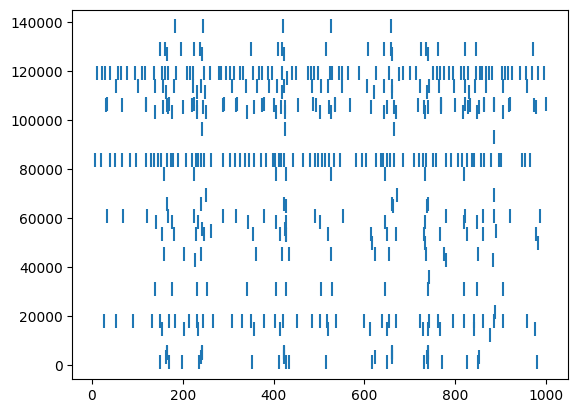

In [31]:
plt.figure()
plt.scatter(times_list[0].cpu(), idx_list[0].cpu(), s=100, marker='|')

if device == 'cuda':
    mem_used_gb = utils.get_vram_usage(device)
    print(f'Used {mem_used_gb:.4f} GB')

# Reproducibility

In the model, firing rates are converted into spike times by a pseudorandom Poisson process. By default, this is not seeded and will result in slightly different firing patterns per simulation. To seed for reproducible runs, we need to initialize a generator

In [32]:
generator = torch.Generator(device=device).manual_seed(42)

This object gets passed into our network at every step, and ensures that the sequence of random numbers we will get is consistent. Note that this doesn't mean all simulations in a batch will be the same, it just means that if you rerun from the same seed you will get the same results each time.

Try running the next cell a couple of times, your results should be exactly the same

Steps:   0%|          | 0/10000 [00:00<?, ?it/s]

Simulation time: 12.32 seconds
Used 1.6823 GB


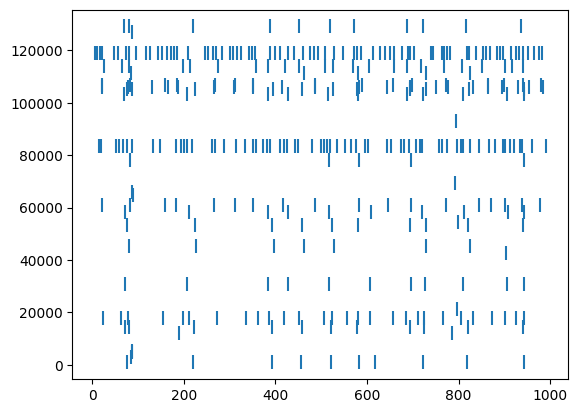

In [39]:
times_list = []
idx_list = []
times_list.append(torch.tensor([], device=device))
idx_list.append(torch.tensor([], device=device))
generator = torch.Generator(device=device).manual_seed(42)
with torch.no_grad():
    start = time.time()
    conductance, delay_buffer, spikes, v, refrac = model.state_init()
    for t in tqdm(range(num_steps), desc='Steps'):
        conductance, delay_buffer, spikes, v, refrac = model(rates, conductance, delay_buffer, spikes, v, refrac, generator=generator)
        times_list[0], idx_list[0] = utils.get_spike_times(spikes[0,:], t, sim_params['dt'], times_list[0], idx_list[0])
    end = time.time()
print(f'Simulation time: {end - start:.2f} seconds')

plt.figure()
plt.scatter(times_list[0].cpu(), idx_list[0].cpu(), s=100, marker='|')

if device == 'cuda':
    mem_used_gb = utils.get_vram_usage(device)
    print(f'Used {mem_used_gb:.4f} GB')

# Multiple Simulations

Lastly, we want to be able to run multiple copies of the model in parallel. We refer to this as a *batch*. Let's modify our simulation parameters to have a larger batch size

In [40]:
sim_params['batch_size'] = 30

Now we need to modify our simulation loop slightly, but most things stay the same.

In [41]:
rates = torch.zeros(sim_params['batch_size'],len(flyid2i), device=device)
rates[:,excitatory_neurons] = stim_rate

model = models.TorchModel(sim_params['batch_size'], weights.shape[0], sim_params['dt'], model_params, weights.to(device=device), device=device)
conductance, delay_buffer, spikes, v, refrac = model.state_init()

if device == 'cuda':
    mem_used_gb = utils.get_vram_usage(device)
    print(f'Used {mem_used_gb:.4f} GB')

Used 2.2323 GB


In [42]:
generator = torch.Generator(device=device).manual_seed(42)

with torch.no_grad():
    start = time.time()
    conductance, delay_buffer, spikes, v, refrac = model.state_init()
    times_list = []
    idx_list = []
    for b in range(sim_params['batch_size']):
        times_list.append(torch.tensor([], device=device))
        idx_list.append(torch.tensor([], device=device))
    for t in tqdm(range(num_steps), desc='Steps'):
        conductance, delay_buffer, spikes, v, refrac = model(rates, conductance, delay_buffer, spikes, v, refrac, generator=generator)
        for b in range(sim_params['batch_size']):
            times_list[b], idx_list[b] = utils.get_spike_times(spikes[b,:], t, sim_params['dt'], times_list[b], idx_list[b])
    end = time.time()
print(f'Simulation time: {end - start:.2f} seconds')

Steps:   0%|          | 0/10000 [00:00<?, ?it/s]

Simulation time: 173.24 seconds


Now that we have our batch of data, we can look at the activity over multiple runs. We will use the same logic as Shiu et al 2024, which is reimplemented within our `utils` module.

In [43]:
df = utils.construct_dataframe(times_list, idx_list, i2flyid, 'P9s_100Hz_b', sim_params['dt'])
df.to_parquet(config_dirs['path_res']+'P9s_100Hz_b.parquet', compression='brotli')
df_spike = utils.load_exps([config_dirs['path_res']+'P9s_100Hz_b.parquet',])
df_rate, df_rate_std = utils.get_rate(df_spike, t_run=1.0, n_run=sim_params['batch_size'], flyid2name=flyid2name)
df_rate.sort_values('P9s_100Hz_b', ascending=False, inplace=True)
df_rate

exp_name,name,P9s_100Hz_b
flyid,,
720575940635872101,P9_right,67.433333
720575940627652358,P9_left,66.733333
720575940613626521,,29.133333
720575940633901395,,23.666667
720575940631924584,,17.200000
...,...,...
720575940630745282,,0.033333
720575940622552675,,0.033333
720575940622158369,,0.033333


In [44]:
relevant_neurons = [neuron for neuron in output_neurons if neuron in df_rate.index]
display(df_rate.loc[relevant_neurons])

exp_name,name,P9s_100Hz_b
flyid,,
720575940626730883,P9_oDN1_left,6.466667
720575940620300308,P9_oDN1_right,1.966667
720575940629327659,DNa02_right,0.500000
720575940604737708,DNa02_left,10.566667
